
# Probability Calibration curves

When performing classification one often wants to predict not only the class
label, but also the associated probability. This probability gives some
kind of confidence on the prediction. This example demonstrates how to
visualize how well calibrated the predicted probabilities are using calibration
curves, also known as reliability diagrams. Calibration of an uncalibrated
classifier will also be demonstrated.


In [15]:
# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause.

## Dataset

We will use a synthetic binary classification dataset with 100,000 samples
and 20 features. Of the 20 features, only 2 are informative, 10 are
redundant (random combinations of the informative features) and the
remaining 8 are uninformative (random numbers). Of the 100,000 samples, 1,000
will be used for model fitting and the rest for testing.



In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

## Calibration curves

### Gaussian Naive Bayes

First, we will compare:

* :class:`~sklearn.linear_model.LogisticRegression` (used as baseline
  since very often, properly regularized logistic regression is well
  calibrated by default thanks to the use of the log-loss)
* Uncalibrated :class:`~sklearn.naive_bayes.GaussianNB`
* :class:`~sklearn.naive_bayes.GaussianNB` with isotonic and sigmoid
  calibration (see `User Guide <calibration>`)

Calibration curves for all 4 conditions are plotted below, with the average
predicted probability for each bin on the x-axis and the fraction of positive
classes in each bin on the y-axis.



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import xgboost as xgb


class Calibrator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Calibrator, self).__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        self.fc.weight.data = torch.eye(input_size)  # Initialize with identity matrix
        self.fc.weight.requires_grad = False
        self.a = nn.Parameter(torch.ones(output_size))  # Initialize a as ones
        self.b = nn.Parameter(torch.zeros(output_size))  # Initialize b as zeros
        # self.a = torch.nn.init.xavier_normal_(self.a, gain=1.0, generator=None) #-> xavier solo per vettori multidimensionali
        nn.init.normal_(self.a, mean=0.0, std=0.1)  # Inizializza a con distribuzione normale
        nn.init.normal_(self.b, mean=0.0, std=0.1)

    def forward(self, x):
        # x = self.fc(x)
        # x = 1 / (1 + torch.exp(-(self.a * x + self.b)))
        x = self.a*x +self.b 
        x = torch.sigmoid(x)
        sum_x = torch.sum(x, dim=1, keepdim=True)  # Calcola la somma degli elementi del vettore
        x = x / sum_x
        
        return x




In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MyCalibrator(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, input_size, output_size, lr=0.02, epochs=200):
        self.base_model = base_model
        self.calibrator = Calibrator(input_size, output_size)
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.calibrator.to(self.device)
        self.is_fitted_ = False
        self.classes_ = None

    def fit(self, X, y):
        # Fit the base model
        self.base_model.fit(X, y)
        # Get the predicted probabilities from the base model
        base_preds = self.base_model.predict_proba(X)
        X_calib, y_calib = torch.FloatTensor(base_preds).to(self.device), torch.LongTensor(y).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.calibrator.parameters(), lr=self.lr)

        for epoch in range(self.epochs):
            self.calibrator.train()
            optimizer.zero_grad()
            outputs = self.calibrator(X_calib)
            loss = criterion(outputs, y_calib)
            loss.backward()
            optimizer.step()
        
        self.classes_ = np.unique(y)
        self.is_fitted_ = True
        return self


    def predict_proba(self, X):
        self.calibrator.eval()
        with torch.no_grad():
            # Get the predicted probabilities from the base model
            base_preds = self.base_model.predict_proba(X)
            X_calib = torch.FloatTensor(base_preds).to(self.device)
            outputs = self.calibrator(X_calib)
        return outputs.cpu().numpy()

In [19]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")
my_model = MyCalibrator(gnb, input_size=2, output_size=2)


clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
    (my_model, "my_model"),
]

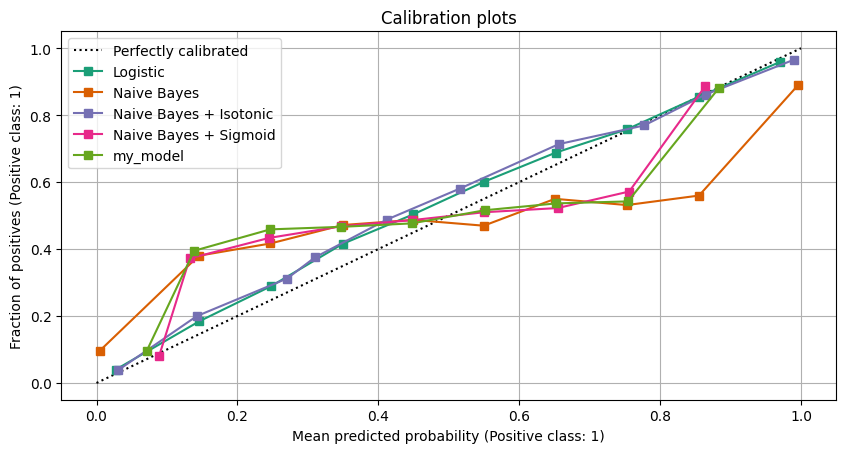

In [20]:
# Creare il grafico delle curve di calibrazione
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

# Adattare i classificatori e visualizzare le curve di calibrazione
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display
  

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
ax_calibration_curve.legend()



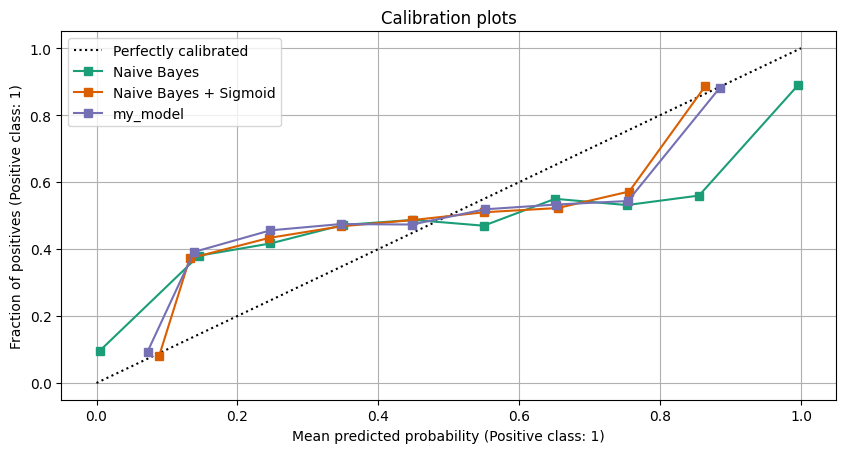

In [21]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")
my_model = MyCalibrator(gnb, input_size=2, output_size=2)


clf_list = [
    (gnb, "Naive Bayes"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
    (my_model, "my_model"),
]


# Creare il grafico delle curve di calibrazione
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

# Adattare i classificatori e visualizzare le curve di calibrazione
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display
  

# Aggiungere la curva di calibrazione del modello custom
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
ax_calibration_curve.legend()